# Web attack detection using CICIDS2017 dataset

Training data: "Intrusion Detection Evaluation Dataset" (CICIDS2017). Description page: https://www.unb.ca/cic/datasets/ids-2017.html

The data set is public. Download link: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/

CICIDS2017 combines 8 files recorded on different days of observation (PCAP + CSV). Used archive: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/GeneratedLabelledFlows.zip

In the downloaded archive GeneratedLabelledFlows.zip the file "Thursday" Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv is selected.

Sources:

* [Sharafaldin2018] Iman Sharafaldin, Arash Habibi Lashkari and Ali A. Ghorbani. Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization. 2018
* [Kostas2018] Kahraman Kostas. Anomaly Detection in Networks Using Machine Learning. 2018 (error was found in assessing the importance of features)
* https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning (error was found in assessing the importance of features)

## Data preprocessing

Source: https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning/blob/master/01_preprocessing.ipynb [Kostas2018].

In [62]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

We use "engine=latin-1" to avoid the "UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 11: invalid start byte" encoding error.

In [63]:
df = pd.read_csv('datasets\Thursday-WorkingHour\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='latin-1')

C:\Users\bharg\AppData\Local\Temp\ipykernel_11112\3483271027.py:1: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets\Thursday-WorkingHour\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='latin-1')


Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv file contains 458968 records, 85 columns.

In [64]:
df.shape

(458968, 85)

The columns "Fwd Header Length" and "Fwd Header Length.1" are identical, the second one is removed, 84 columns remain.

In [65]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(458968, 84)

When assessing the distribution of labels, it turns out that out of 458968 records there are many blank records ("BENIGN" - benign background traffic).

In [66]:
df['Label'].unique()

array(['BENIGN', 'Web Attack \x96 Brute Force', 'Web Attack \x96 XSS',
       'Web Attack \x96 Sql Injection', nan], dtype=object)

In [67]:
df['Label'].value_counts()

Label
BENIGN                        168186
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: count, dtype: int64

Delete blank records.

In [68]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [69]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

Replace the NaN values and infinity values with -1.

In [70]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.

In [71]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [72]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

### Undersampling against unbalance

Dataset is unbalanced: total records = 170366, "BENIGN" records = 168186, records with attacks much less: 1507 + 652 + 21 = 2180.

In [73]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [74]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [75]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

Label
BENIGN                        168186
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: count, dtype: int64

We use **undersampling** to correct class imbalances: we remove most of the "BENIGN" records.

Form a balanced dataset web_attacks_balanced.csv in proportion: 30% attack (2180 records), 70% benign data (2180 / 30 * 70 ~ = 5087 records).

Algorithm to form a balanced df_balanced dataset:

* All the records with the attacks are copied to the new dataset.
* There are two conditions for copying "BENIGN" records to the new dataset:
 
     1. The next record is copyied with the benign_inc_probability.
     2. The total number of "BENIGN" records must not exceed the limit of 5087 records.

Сalculate the probability of copying a "BENIGN" record. The enlargement multiplier is used to get exactly 70% benign data (5087 records).

In [76]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.

In [77]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [78]:
df_balanced['Label'].value_counts()

Label
BENIGN                        5087
Web Attack  Brute Force      1507
Web Attack  XSS               652
Web Attack  Sql Injection      21
Name: count, dtype: int64

If necessary, we can keep a single class of attack for experiments.

In [79]:
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
# df_balanced['Label'].value_counts()

In [80]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

### Preparing data for training

In [81]:
df = pd.read_csv('web_attacks_balanced.csv')

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [82]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

If necessary, we will work with our own dataset.

In [83]:
#!wget https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/mix_labelled.zip -O mix_labelled.zip
#!unzip -u mix_labelled.zip

In [84]:
#df = pd.read_csv('mix_labelled.csv')
#excluded = ['Flow Key', 'Flow Bytes/s', 'Flow MB/s', 'Fwd IAT Min', 
#            'Flow IAT Min', 'Packet Length Mean', 'Average Fwd Segment Size', 'Subflow Fwd Bytes',
#            'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Mean',
#            'Average Bwd Segment Size', 'Bwd Packet Length Mean', 'Packet Length List', 'Total Fwd Packets',
#            'Packet Length Std', 'Packet Length Variance', 'Total Backword Packets', 'Fwd Packet Length Std',
#            'Total Length of Bwd Packets', 'Bwd Header Length']
#df = df.drop(columns=excluded, errors='ignore')

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [85]:
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

Below at the stage of importance estimation the "Init_Win_bytes_backward" feature has the maximum value. After viewing the source dataset, it seems that an inaccuracy was made in forming the dataset. 

It turns out that it is possible to make a fairly accurate classification by one feature.

Description of features: http://www.netflowmeter.ca/netflowmeter.html

     Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
     Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction

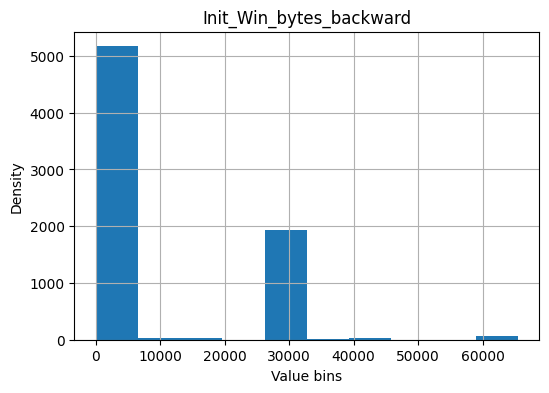

In [86]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

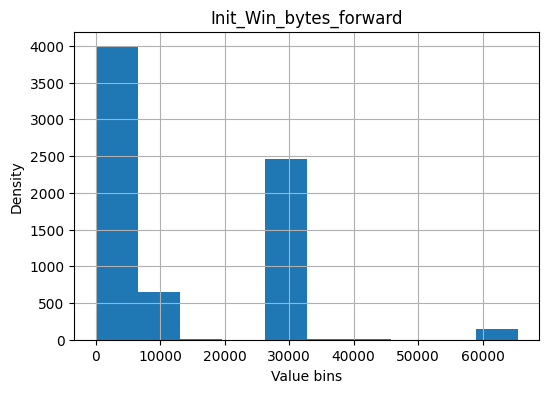

In [87]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [88]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2, errors='ignore')

In [89]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 74) (7267,)


## Feature importance

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 3551, 1: 1535}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)
 
In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.
 
By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.95874263, 0.93909627, 0.95874263, 0.956778  , 0.95284872,
       0.94695481, 0.94685039, 0.9488189 , 0.9488189 , 0.97440945])

In [92]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Packet Length Mean <= 0.75
|   |--- Fwd IAT Std <= 3527451.25
|   |   |--- class: 0
|   |--- Fwd IAT Std >  3527451.25
|   |   |--- Fwd IAT Min <= 15046.50
|   |   |   |--- class: 1
|   |   |--- Fwd IAT Min >  15046.50
|   |   |   |--- class: 0
|--- Packet Length Mean >  0.75
|   |--- Subflow Fwd Bytes <= 34804.00
|   |   |--- class: 0
|   |--- Subflow Fwd Bytes >  34804.00
|   |   |--- class: 1



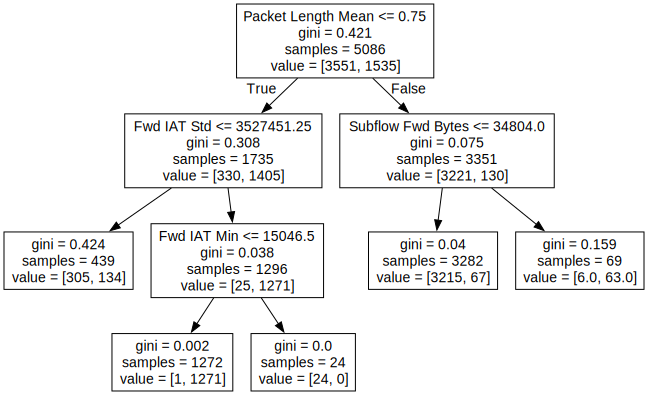

In [93]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

Analyze the confusion matrix. Which classes are confidently classified by the model?

In [94]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 1536, 1: 645}

In [95]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1536,    0],
       [  87,  558]], dtype=int64)

### Importance evaluation using SelectFromModel (still one decision tree)

Source: https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/select-from-model-nslkdd.ipynb

In [96]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16504704, 0.        , 0.02594388, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.74960996,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05939912, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [97]:
sfm.threshold_

0.013513513513513514

In [98]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 4


In [99]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Packet Length Mean - 0.7496099643990195
1.	Fwd IAT Std - 0.16504704006388515
2.	Subflow Fwd Bytes - 0.05939911706966618
3.	Fwd IAT Min - 0.02594387846742918
4.	Idle Min - 0.0
5.	Bwd IAT Std - 0.0
6.	Fwd IAT Mean - 0.0
7.	Fwd IAT Max - 0.0
8.	Bwd IAT Total - 0.0
9.	Bwd IAT Mean - 0.0


### Evaluation of importance using RandomForestClassifier.feature_importances_ (move from one tree to a random forest, classification quality increases)

In [100]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 0.99 
R^2 Validation Score: 0.98 
Out-of-bag Score: 0.98


In [101]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:20]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#51	0.085	Average Packet Size
2.	#13	0.078	Flow Bytes/s
3.	#38	0.065	Max Packet Length
4.	#7	0.061	Fwd Packet Length Mean
5.	#39	0.057	Packet Length Mean
6.	#23	0.056	Fwd IAT Min
7.	#61	0.055	Subflow Fwd Bytes
8.	#52	0.051	Avg Fwd Segment Size
9.	#3	0.045	Total Length of Fwd Packets
10.	#15	0.033	Flow IAT Mean
11.	#5	0.030	Fwd Packet Length Max
12.	#21	0.028	Fwd IAT Std
13.	#33	0.024	Fwd Header Length
14.	#0	0.024	Flow Duration
15.	#14	0.024	Flow Packets/s
16.	#16	0.022	Flow IAT Std
17.	#35	0.021	Fwd Packets/s
18.	#19	0.018	Fwd IAT Total
19.	#20	0.017	Fwd IAT Mean
20.	#22	0.016	Fwd IAT Max


For comparison, the results of the study [Sharafaldin2018] (compare relatively, without taking into account the multiplier):
 
* Init Win F.Bytes 0.0200
* Subflow F.Bytes 0.0145
* Init Win B.Bytes 0.0129
* Total Len F.Packets 0.0096

And incorrect results [Kostas2018] (error was found in assessing the importance of features, line: *impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})*, the importances[0:20] sample does not take into account that the values are not sorted in descending order):
 
* Flow Bytes/s 0.313402
* Total Length of Fwd Packets 0.304917
* Flow Duration 0.000485
* Fwd Packet Length Max 0.00013

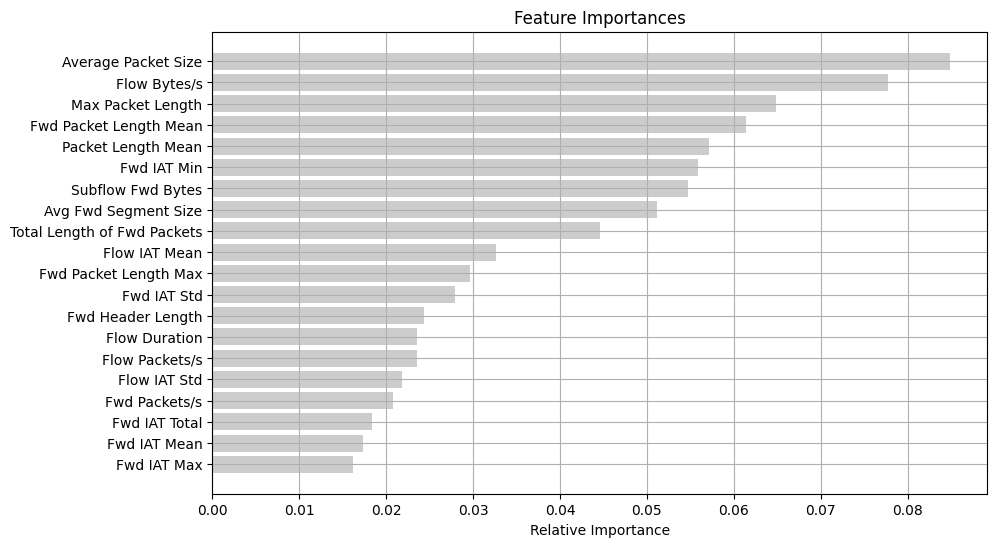

In [102]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [103]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1513,   23],
       [  18,  627]], dtype=int64)

Next, for experiments, we keep the first max_features of features with maximum importance.

In [104]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Average Packet Size',
 'Flow Bytes/s',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Packet Length Mean',
 'Fwd IAT Min',
 'Subflow Fwd Bytes',
 'Avg Fwd Segment Size',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd Packet Length Max',
 'Fwd IAT Std',
 'Fwd Header Length',
 'Flow Duration',
 'Flow Packets/s',
 'Flow IAT Std',
 'Fwd Packets/s',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Max']

## Analysis of selected features

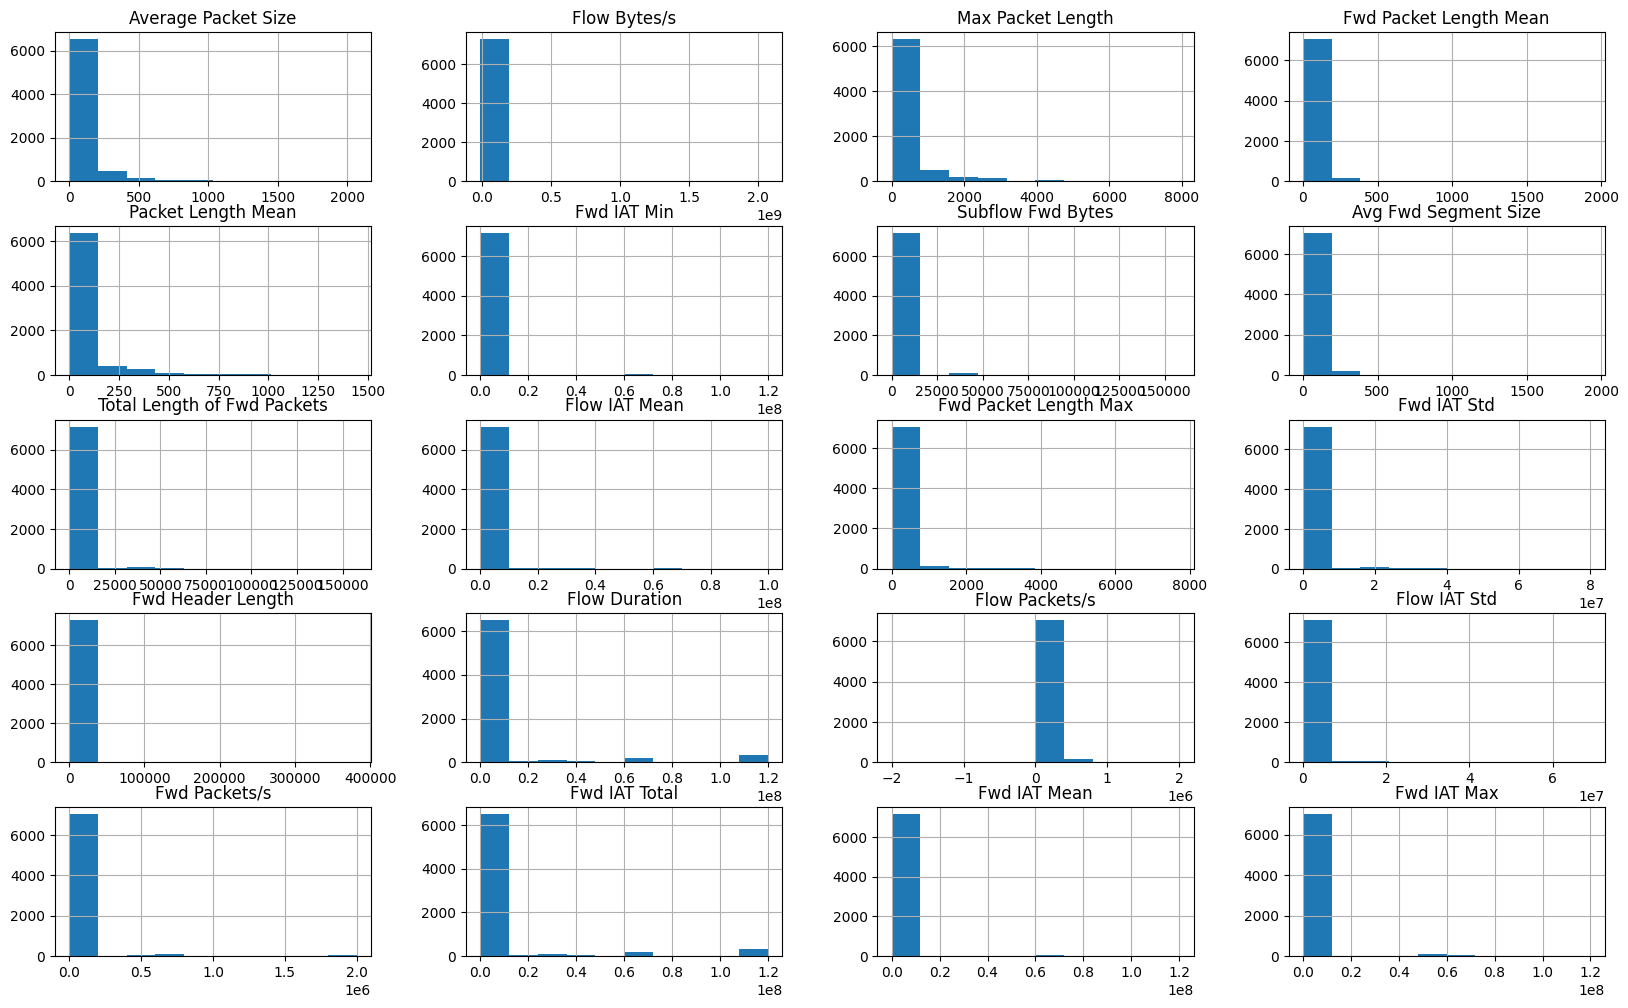

In [105]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

Install Facets Overview

https://pair-code.github.io/facets/

In [106]:
!pip install facets-overview

Create the feature stats for the datasets and stringify it.

In [107]:
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train + test', 'table': df[webattack_features]}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

f:\bharg\Python\lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Display the facets overview visualization for this data.

In [108]:
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

C:\Users\bharg\AppData\Local\Temp\ipykernel_11112\3688853136.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


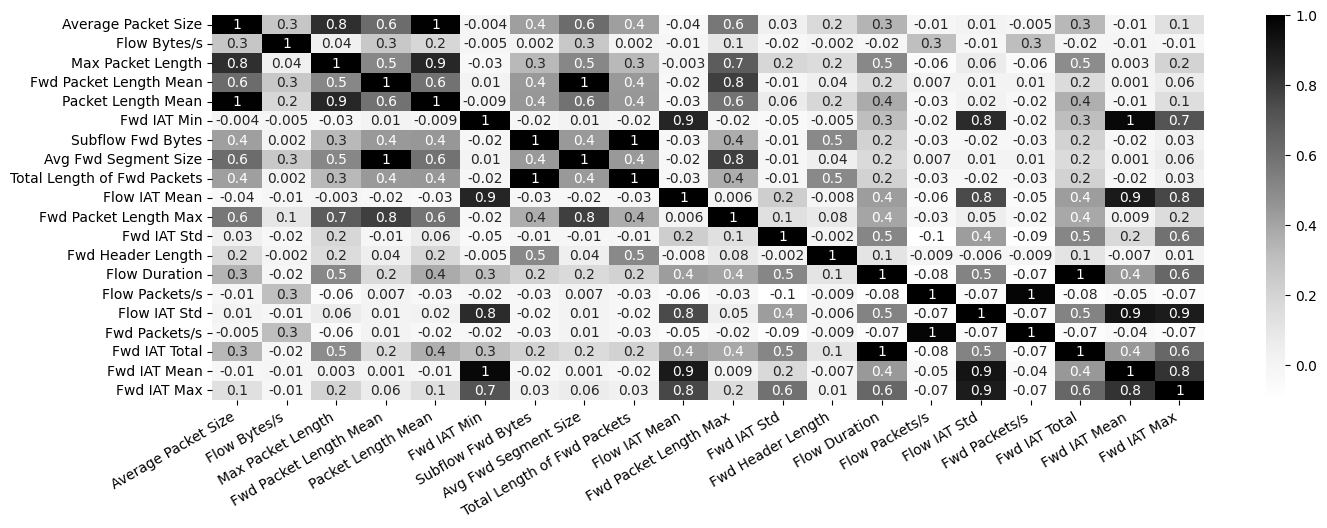

In [109]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

Remove correlated features.

In [110]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes', 
                 'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Average Packet Size',
 'Flow Bytes/s',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd Packet Length Max',
 'Fwd IAT Std',
 'Fwd Header Length']

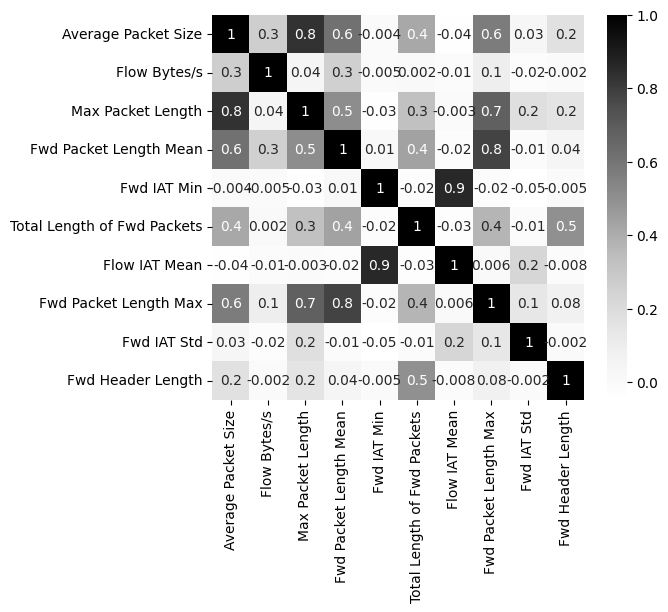

In [111]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys');

## Hyperparameter selection

Reopen the dataset.

In [112]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(7267, 10) (7267,)


If necessary, we will work with our own dataset.

In [113]:
#df = pd.read_csv('mix_labelled.csv')
#y = df['Label'].values
#X = df[webattack_features]
#print(X.shape, y.shape)

We get the list of RandomForestClassifier parameters.

In [114]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

For search of quasi-optimal value of one parameter we fix the others.

In [115]:
parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 20, 30, 50]}
scoring = 'accuracy'
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')
results = gcv.cv_results_

CPU times: total: 24 s
Wall time: 38 s


In [116]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.303057,0.226285,0.029715,0.017457,1,3,3,10,"{'max_depth': 1, 'max_features': 3, 'min_sampl...",0.929849,...,0.913150,0.912691,0.911621,0.914220,0.909174,0.908730,0.908271,0.913163,0.911243,0.002076
1,0.141777,0.047979,0.020604,0.009296,2,3,3,10,"{'max_depth': 2, 'max_features': 3, 'min_sampl...",0.942228,...,0.955046,0.955046,0.954587,0.955199,0.955352,0.951384,0.951231,0.955206,0.954391,0.001563
2,0.341690,0.378505,0.036137,0.077368,3,3,3,10,"{'max_depth': 3, 'max_features': 3, 'min_sampl...",0.935351,...,0.957492,0.957187,0.956881,0.957951,0.957492,0.953677,0.953677,0.957652,0.956684,0.001545
3,0.183878,0.073501,0.025610,0.028868,4,3,3,10,"{'max_depth': 4, 'max_features': 3, 'min_sampl...",0.946355,...,0.967278,0.970948,0.966361,0.966667,0.967125,0.968353,0.964073,0.972940,0.967494,0.002592
4,0.148501,0.034083,0.009186,0.008507,5,3,3,10,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.957359,...,0.976911,0.977064,0.975688,0.977676,0.972324,0.975845,0.975998,0.980125,0.975674,0.002440


### Grid search

In [121]:
parameters = {'n_estimators': [30, 50, 70], 
              'min_samples_leaf': [3, 5, 7],
              'max_features': [3, 5, 7, 10], 
              'max_depth': [10, 17, 23]}

# parameters = {'n_estimators': [250]}

The operation may take a long time, 3-5 minutes depending on the computer performance.

In [122]:
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=3, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')

CPU times: total: 4min 4s
Wall time: 6min 38s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [10, 17, 23],
                         'max_features': [3, 5, 7, 10],
                         'min_samples_leaf': [3, 5, 7],
                         'n_estimators': [30, 50, 70]},
             refit='f1', return_train_score=True, scoring='accuracy')

Let's take a look at the results of the parameter selection.

In [123]:
gcv.best_estimator_ 

RandomForestClassifier(max_depth=23, max_features=3, min_samples_leaf=3,
                       n_estimators=30, random_state=1)

In [124]:
gcv.best_params_

{'max_depth': 23, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 30}

In [125]:
gcv.best_score_

0.9782576689876435

## Final model

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5086, 10) (5086,)
(2181, 10) (2181,)


In [127]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
# rfc = RandomForestClassifier(n_estimators=250, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [128]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
    
for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#2	0.410	Max Packet Length
2.	#0	0.257	Average Packet Size
3.	#8	0.139	Fwd IAT Std
4.	#5	0.051	Total Length of Fwd Packets
5.	#6	0.048	Flow IAT Mean
6.	#4	0.034	Fwd IAT Min
7.	#9	0.027	Fwd Header Length
8.	#3	0.024	Fwd Packet Length Mean
9.	#7	0.007	Fwd Packet Length Max
10.	#1	0.004	Flow Bytes/s


In [129]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1512,   24],
       [  25,  620]], dtype=int64)

In [130]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9775332416322787
Precision = 0.9627329192546584
Recall = 0.9612403100775194
F1 = 0.9619860356865787


## Model saving

In [131]:
!pip install --upgrade pip setuptools wheel

In [132]:
import pickle
with open('webattack_detection_rf_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

## Model approbation

Open the previously saved model.

In [133]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

Reopen the dataset.

In [134]:
df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = df['Label'].values
X_test = df[webattack_features]
print(X_test.shape, y_test.shape)

(7267, 10) (7267,)


If necessary, we will work with our own dataset.

In [135]:
#df = pd.read_csv('mix_labelled.csv')
#y_test = df['Label'].values
#X_test = df[webattack_features]
#print(X_test.shape, y_test.shape)

In [136]:
X_test.head()

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd Packet Length Max,Fwd IAT Std,Fwd Header Length
0,63.500000,1.361963e+06,79.0,32.000000,1.0,64.0,54.333333,32.0,0.000,64.0
1,221.500000,1.727494e+06,179.0,176.000000,49.0,352.0,137.000000,176.0,0.000,64.0
2,240.957983,2.462418e+02,3069.0,185.833333,1.0,13380.0,986834.771200,1313.0,7324638.435,2320.0
3,80.000000,1.408163e+06,94.0,44.000000,49.0,88.0,65.333333,44.0,0.000,64.0
4,30.000000,5.393258e+05,24.0,24.000000,1.0,48.0,59.333333,24.0,0.000,64.0


In [137]:
import time
seconds = time.time()
y_pred = rfc.predict(X_test)
print("Total operation time:", time.time() - seconds, "seconds")

print("Benign records detected (0), attacks detected (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Total operation time: 0.06659865379333496 seconds
Benign records detected (0), attacks detected (1):


{0: 5091, 1: 2176}

Confusion matrix:

      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

In [138]:
confusion_matrix(y_test, y_pred)

array([[5033,   54],
       [  58, 2122]], dtype=int64)

In [139]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9845878629420669
Precision = 0.9751838235294118
Recall = 0.9733944954128441
F1 = 0.9742883379247016


Manual calculation of the confusion matrix:
    
    array([[5075,   12],
           [   1, 2179]], dtype=int64)
  
      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

    Точность
    Precision = TP / (TP + FP) = 2179 / (2179 + 12) = 0.9945230488361478

    Полнота
    Recall = TP / (TP + FN) = 2179 / (2179 + 1) = 0.9995412844036697

    F-мера, параметр = 1, гармоническое среднее точности и полноты, множитель = 2
    F1 = 2 * (precision * recall) / (precision + recall) = 0.9970258522077328

    Доля правильных ответов
    Accuracy = TP + TN / (TP + TN + FP + FN) = (2179 + 5075) / 7267 = 0.998211091234347

In [140]:
predict = pd.DataFrame({'Predict': rfc.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
result = X_test.join(label).join(predict)

In [141]:
result[result['Predict'] == 1]

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd Packet Length Max,Fwd IAT Std,Fwd Header Length,Label,Predict
345,0.000000,0.000000,0.0,0.000000,365.0,0.0,365.0000,0.0,0.000,64.0,0,1
435,0.000000,0.000000,0.0,0.000000,0.0,0.0,81.0000,0.0,0.000,32.0,1,1
438,0.000000,0.000000,0.0,0.000000,0.0,0.0,84.0000,0.0,0.000,32.0,0,1
503,0.000000,0.000000,0.0,0.000000,0.0,0.0,21.0000,0.0,0.000,32.0,0,1
545,549.319149,1206.155288,2896.0,211.678571,705.0,5927.0,465330.5217,561.0,1474704.318,904.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6919,0.000000,0.000000,0.0,0.000000,0.0,0.0,88.0000,0.0,0.000,32.0,0,1
6955,0.000000,0.000000,0.0,0.000000,0.0,0.0,67.0000,0.0,0.000,32.0,0,1
7171,0.000000,0.000000,0.0,0.000000,0.0,0.0,99.0000,0.0,0.000,32.0,0,1
7178,0.000000,0.000000,0.0,0.000000,283.0,0.0,283.0000,0.0,0.000,64.0,0,1


In [142]:
result[410:430]

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd Packet Length Max,Fwd IAT Std,Fwd Header Length,Label,Predict
410,9.000000,1.690141e+05,6.0,6.000000,71.0,12.0,7.100000e+01,6.0,0.000000e+00,40.0,0,0
411,550.757576,1.316797e+04,1460.0,66.000000,107.0,792.0,4.313259e+04,405.0,3.554310e+04,252.0,0,0
412,110.500000,5.341055e+03,111.0,55.000000,0.0,55.0,3.108000e+04,55.0,0.000000e+00,20.0,0,0
413,86.250000,3.472222e+05,105.0,45.000000,4.0,90.0,2.880000e+02,45.0,0.000000e+00,40.0,0,0
414,81.750000,1.510638e+06,99.0,43.000000,48.0,86.0,6.266667e+01,43.0,0.000000e+00,64.0,0,0
415,247.863636,1.144437e+04,1430.0,75.230769,2.0,978.0,2.268948e+04,386.0,8.375482e+04,272.0,0,0
416,15.250000,2.180982e+03,37.0,16.333333,192.0,49.0,8.406000e+03,37.0,6.385174e+02,60.0,0,0
417,16.333333,2.377004e+04,31.0,14.333333,4.0,43.0,9.045000e+02,31.0,1.273499e+03,60.0,0,0
418,95.750000,4.127360e+00,114.0,54.000000,80700000.0,108.0,2.690000e+07,58.0,0.000000e+00,40.0,0,0
419,342.052632,6.322107e+04,1460.0,166.875000,3.0,1335.0,5.711000e+03,789.0,1.343151e+04,172.0,0,0
